In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)


32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## training MLP same as we did in 03_MLP.ipynb finally

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)



parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8050
  20000/ 200000: 2.5518
  30000/ 200000: 2.8035
  40000/ 200000: 2.0476
  50000/ 200000: 2.7033
  60000/ 200000: 2.3179
  70000/ 200000: 2.0966
  80000/ 200000: 2.3344
  90000/ 200000: 2.2155
 100000/ 200000: 2.0712
 110000/ 200000: 2.4086
 120000/ 200000: 1.8661
 130000/ 200000: 2.3103
 140000/ 200000: 2.2350
 150000/ 200000: 2.1742
 160000/ 200000: 2.1190
 170000/ 200000: 1.7579
 180000/ 200000: 2.0183
 190000/ 200000: 1.8186


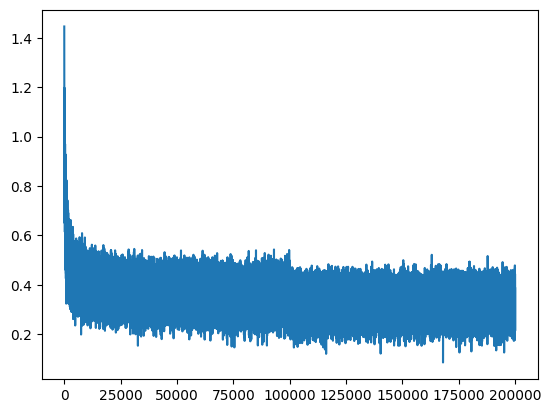

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # this decorator disables gradient tracking for operations done by the following function, almost like all the tensor created here have requires_grad= False, we can also use a context manager with torch.nograd
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1256532669067383
val 2.1684703826904297


In [10]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out =[]
    context = [0]*block_size # initialize with all ...
    while True:
        es = C[torch.tensor([context])]
        hs = torch.tanh(es.view(1,-1) @ W1 + b1)
        logits = hs @ W2 + b2
        probs = F.softmax(logits,dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1,generator=g).item()
        # shift the context window and track the samples
        context = context[1:]+[ix]
        out.append(ix)
        # if we sample the '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlah.
amille.
khy.
mili.
taty.
skanden.
jazonen.
den.
art.
kaqui.
nextara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearyn.
kai.


## ISSUES WITH THE NETWORK
### 1. We can see from the loss plot that we are starting with a very high loss - means that the parameters initialization is poor and we can improve it


### solution for problem 1 -->calculating expected initial loss

In [11]:
# at initialization we have no reason to believe any characters to be more likely than others
# so we would want that prop for any char should be 1/27
# then loss would be -log prob
expected_initial_loss = -torch.tensor(1/27.0).log() # 1/27 is the prob to predict the next character, initially same for all chars
print(expected_initial_loss)

# what is happening right now that due to random initialization, some chars have very high probs and some very low
# Note- we don't want the weights to be same at initialization
# we want the logits coming out of the network (and hence probabilities for each class/char) to be the same


tensor(3.2958)


In [12]:
#   logits = h @ W2 + b2 # (N, vocab_size)
# since we want the logits to be roughly zeros(or same but for symmetry taken as zero), we don't want to be adding a random bias term
# so we do --> b2 = torch.randn(vocab_size,                      generator=g) * 0 # multiplying by zero

# we are also multiplying the hidden state(h) with w2, so for logits to be near zeros, we want w2 to be very small
# so we do --> W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # scaling down w2 to smaller values

# with these the  initial loss should be closer to expected



In [13]:
# Note - can we just multiply W2 by zero coz that would make logits exactly zeros(which we wanted)
# Reason we don't do this coz

# retraining the network with the above modifications

In [14]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [15]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


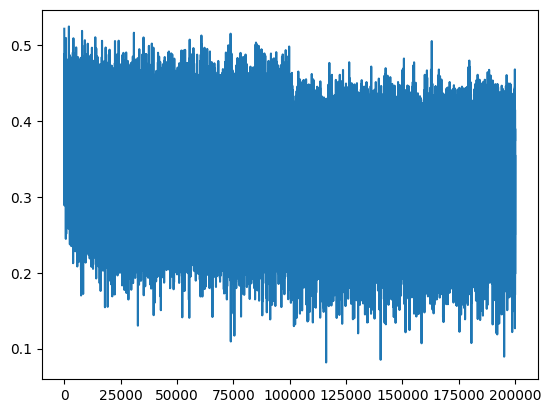

In [16]:
plt.plot(lossi)

In [17]:
# the plot of the loss now doesn't have the hockey shape apperance
# coz now our initialization is better, hence initial loss is better, and those easy gains in the beginning are gone
# this is true for any neural net

In [18]:

@torch.no_grad() # this decorator disables gradient tracking for operations done by the following function, almost like all the tensor created here have requires_grad= False, we can also use a context manager with torch.nograd
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1 # h pre/before activations
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695888996124268
val 2.131074905395508


In [19]:
# we get slightly better loss because, now instead of spending the first several iterations to get those easy gains
# those iterations are spent on actually improving the network,

## ISSUES WITH THE NETWORK
### 2. Dead Neurons / highly active activations - Deeper lurking problem with the initialization of the network


In [20]:
# following plot shows that the tanh is very active, most of the values are -1,1

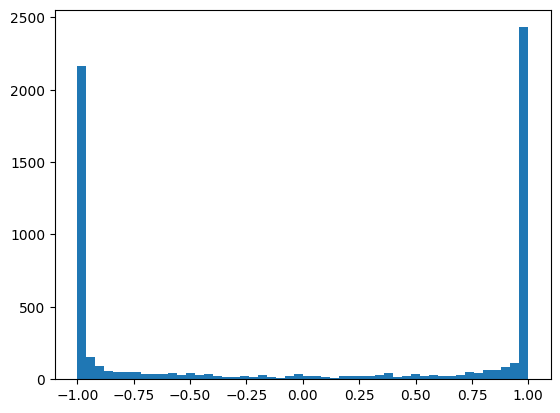

In [21]:
plt.hist(h.view(-1).tolist(),50);

In [22]:
# to know why this is happening we can look at the values pre/before going into activation
# we can see from the plot below that the values are very broadly distributed and hence getting converted to -1,1
# tanh will become very close to -1/1 for values near/greater than -4/4
torch.tanh(torch.tensor([0,1,2,3,4,5,6,7,8,9,10]))

tensor([0.0000, 0.7616, 0.9640, 0.9951, 0.9993, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])

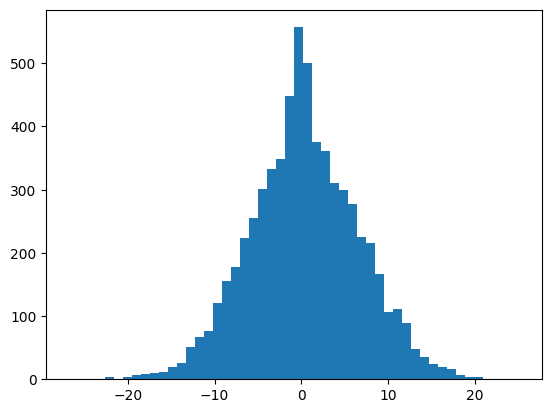

In [23]:
plt.hist(hpreact.view(-1).tolist(),50);

In [24]:
# this can be a big issue in the training of neural network
# we can see that form the following tanh implementation in micrograd, t = tanh(x), when t = +=1 --> grad becomes 0 because of (1-t^2)--> out.grad just stops flowing in the network(zero)
# we can also see this directly from the slope of tanh graphs, becomes close to 0 very quickly as we go from 0 towards +ve/-ve
# basically the gradient just vanishes
# also if the tanh value is 0, self.grad = out.grad --> meaning that the gradient just passes through


#def tanh(self):
#    x = self.data
#    t = (math.exp(2*x) -1)/(math.exp(2*x) +1)
#    out = Value(t, (self,),'tanh')
#   
#    def _backward():
#        self.grad += (1-t**2)*out.grad
#    out._backward = _backward
#    return out

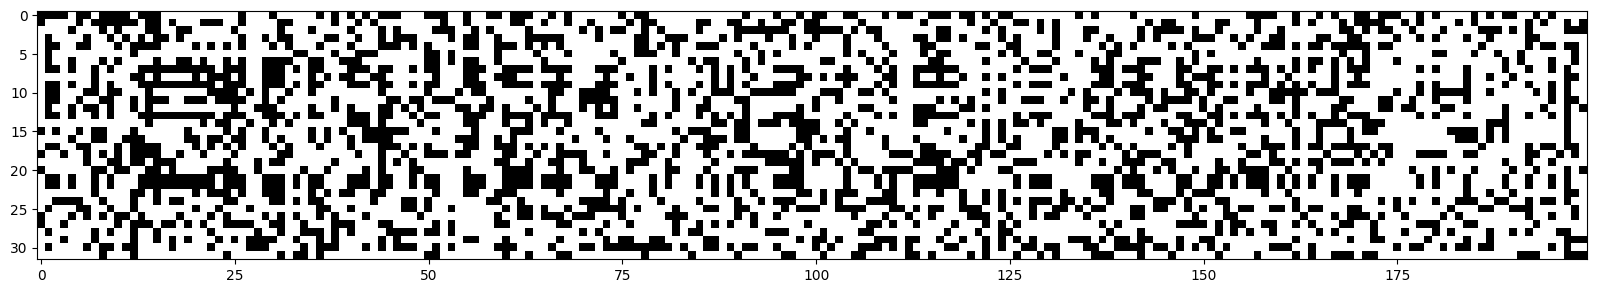

In [26]:
# So the concern is that if all the outputs(h) are in the flat region of the tanh, 
#then the gradients that are flowing through the network will just gets destroyed at this layer
# basically at this layer, the gradients will just vanish
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')
# this is a boolean tensor - white if condition true, black if false
# image shows 32 examples (batch size) and 200 hidden neurons
# the image shows that lot of the points are white --> means all these tanh neurons were very very active, and in the flat tail --> in all these cases the backward gradient would be destroyed


#### we would specially have a big problem if any of the column here was completely white,
#### because that means for all the examples in the batch, no example ever activates the tanh in the active part of the tanh (not the tail)
#### this would mean we have dead neuron in the network
#### if all the examples land up in the tail of tanh, then this neuron will never learn, its dead


___
<img src="./activation_funcs.png" alt="Activation Functions" style="width: 50%;">
 
___



#

In [ ]:
#### this not only true for tanh but lot of other non-linearities (activation functions)
#### sigmoid will also have the same issue coz its a squashing function
#### same will be also apply to relu, coz it has a flat region for negative values

In [29]:
# the issue of dead neurons can happen at initilization
# but it can also happen during training/optimisation beacuse 
# the relu neurons are changing shifting etc during training and 
# because of a high gradient somewhere, they get knocked off and nothing ever activates them
# basically the high gradient can push the neuron’s output into the negative region of the input space permanently.
# Once the neuron outputs zero, it stops receiving updates because the gradient (which is zero) gets propagated backward. Thus, the neuron is effectively “dead.”

Why Dead Neurons Occur
Example for Relu

	1.	Initialization Issue:
	•	Scenario: During initialization, if the weights are set such that a neuron has a large negative bias, the output of the neuron will be zero for many inputs.
	•	Effect: If this neuron outputs zero during the forward pass, its gradient will also be zero during backpropagation because the derivative of ReLU is zero for negative inputs.
	2.	Training Issue:
	•	Scenario: During training, if a neuron experiences a very large negative gradient, the weight updates can push the neuron’s output into the negative region of the input space permanently.
	•	Effect: Once the neuron outputs zero, it stops receiving updates because the gradient (which is zero) gets propagated backward. Thus, the neuron is effectively “dead.”

## addressing this problem and retraining the network 


In [ ]:
# in summary
# hpreact were getting extreme values(spread out in the distribution) so h lies in flat tail regions of tanh
# so we want squash these values towards zero little bit to decrease the intent of above
# hence multiply W1 and b1 by small values
#  because hpreact = embcat @ W1 + b1 

In [54]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [55]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  #break

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


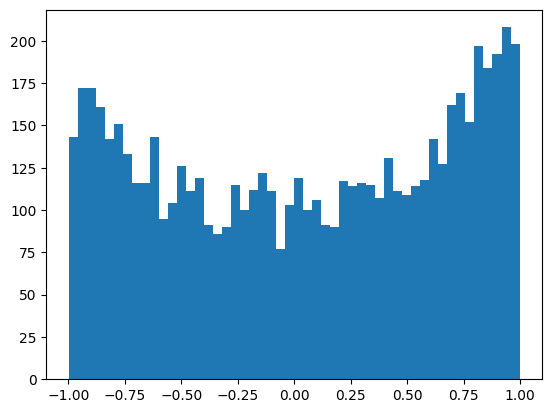

In [51]:
# this plot is only after the first iteration, since we want to plot values for the initialisation and not after the model has trained 
# we can see now that at initialisation h is not completely in the tail regions
plt.hist(h.view(-1).tolist(),50);

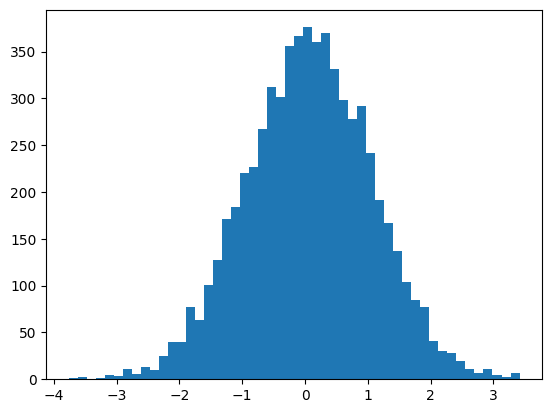

In [52]:
# this plot is only after the first iteration, since we want to plot values for the initialisation and not after the model has trained 
# we can see now that at initialisation h is not completely in the tail regions
# because h pre/before activation is not so dispersed
plt.hist(hpreact.view(-1).tolist(),50);

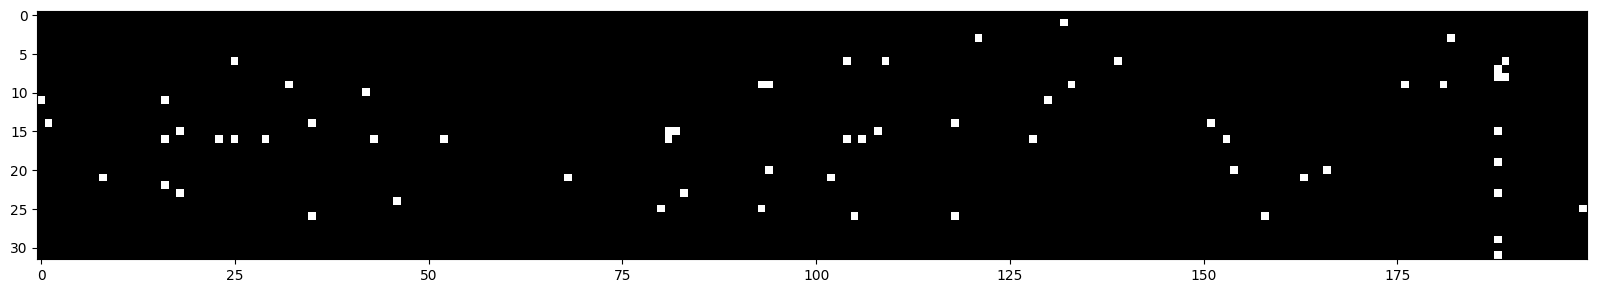

In [53]:
# this plot is only after the first iteration, since we want to plot values for the initialisation and not after the model has trained 
# we can see now that at initialisation h is not completely in the tail regions
# because h pre/before activation is not so dispersed
# hence the number of whites have decreased substantially
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

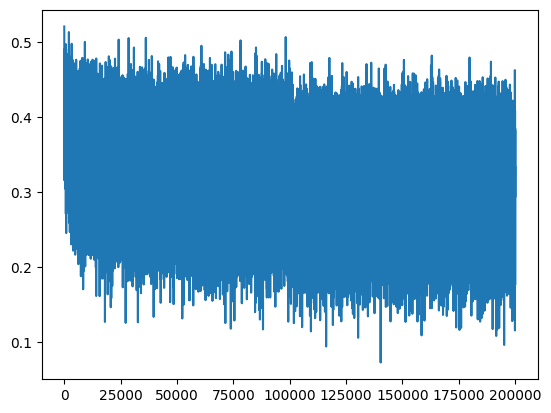

In [57]:
# after training completely
plt.plot(lossi)

In [58]:
@torch.no_grad() # this decorator disables gradient tracking for operations done by the following function, almost like all the tensor created here have requires_grad= False, we can also use a context manager with torch.nograd
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1 # h pre/before activations
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026785373687744


loss log
original:
train 2.1256
val 2.1684

fix softmax confidently wrong:
train 2.0695
val 2.1310

fix tanh layer too saturated at init:
train 2.0355
val 2.1026

Although it may seem like adressing these issues is not giving too many gains, but its only coz the model is small and hence(more forgiving to these things)
In practice when the models get bigger, the problems caused by these issues stack up and is substantial and should be addressed as such


## we multiple weights and biases with some 'magic' values at initialization, but we don't do it by hand in practice
## there's better ways to do this, lets look at them

1. initilizing weights using Kaiming/He Initialisation


In [ ]:
# we want the values pre/before activation to be roughly gaussian(0 mean 1 std) atleast at initialization, not to small (tanh wont do much), not too big(tanh will become saturated)